### 🧠 The Elegant Data Hacks - Official Notebook
This notebook is part of the content published on Medium:
https://medium.com/the-elegant-data-hacks

- All data here is simulated.

- All analyses are fueled by curiosity, coffee, and a dash of sarcasm.

- And all randomness is aligned with the universal truth:

import numpy as np
np.random.seed(42)  # Because 42 is the answer to life, the universe, and everything.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
np.random.seed(42)  # Because 42 is the answer to life, the universe, and everything

# Simulating 100 users with random entry dates throughout March 2025
num_users = 100
start_date = pd.to_datetime("2025-03-01")
users = [f"user_{i}" for i in range(num_users)]

# Randomly assign each user an entry date within a 30-day window
entry_dates = np.random.choice(pd.date_range(start_date, periods=30), num_users)

data = []

# Simulate usage sessions for each user
for user, entry in zip(users, entry_dates):
    num_sessions = np.random.randint(1, 10)  # Each user has between 1 and 9 sessions
    days_active = np.sort(
        np.random.choice(range(0, 21), size=num_sessions, replace=False)
    )  # Choose unique active days within 3 weeks of entry
    
    # Record each session as a new row
    for day in days_active:
        data.append({
            "user_id": user,
            "date": entry + pd.Timedelta(days=day)
        })

# Create a DataFrame from the simulated data
df = pd.DataFrame(data)
df["date"] = pd.to_datetime(df["date"])  # Ensure the date column is properly formatted

df.head()

,user_id,date
0,user_0,2025-03-09
1,user_0,2025-03-16
2,user_0,2025-03-23
3,user_0,2025-03-26
4,user_1,2025-03-23


In [ ]:
# Determine each user's entry date (first recorded usage)
df["entry_date"] = df.groupby("user_id")["date"].transform("min")

# Assign the cohort week based on the user's entry date
# Each cohort represents the week the user first became active
df["cohort_week"] = df["entry_date"].dt.to_period("W").apply(lambda r: r.start_time)

# Determine the week when each usage event occurred
df["usage_week"] = df["date"].dt.to_period("W").apply(lambda r: r.start_time)

# Define the user's position in the cohort timeline
# Example: 0 = entry week, 1 = one week after entry, and so on
df["cohort_index"] = ((df["usage_week"] - df["cohort_week"]).dt.days // 7).astype(int)

# Format cohort and usage weeks as plain dates (no time component)
df["cohort_week"] = df["cohort_week"].dt.date
df["usage_week"] = df["usage_week"].dt.date

# Count unique users by cohort and week index
cohort_data = df.groupby(["cohort_week", "cohort_index"])["user_id"].nunique().reset_index()

# Reshape the data into a matrix: rows = cohorts, columns = weeks since entry
cohort_pivot = cohort_data.pivot(index="cohort_week", columns="cohort_index", values="user_id")

cohort_pivot

cohort_index,0,1,2,3
cohort_week,,,,
2025-03-03,18.0,17.0,15.0,6.0
2025-03-10,20.0,18.0,12.0,7.0
2025-03-17,19.0,15.0,12.0,3.0
2025-03-24,25.0,19.0,20.0,6.0
2025-03-31,12.0,9.0,6.0,NaN
2025-04-07,5.0,1.0,NaN,NaN
2025-04-14,1.0,NaN,NaN,NaN


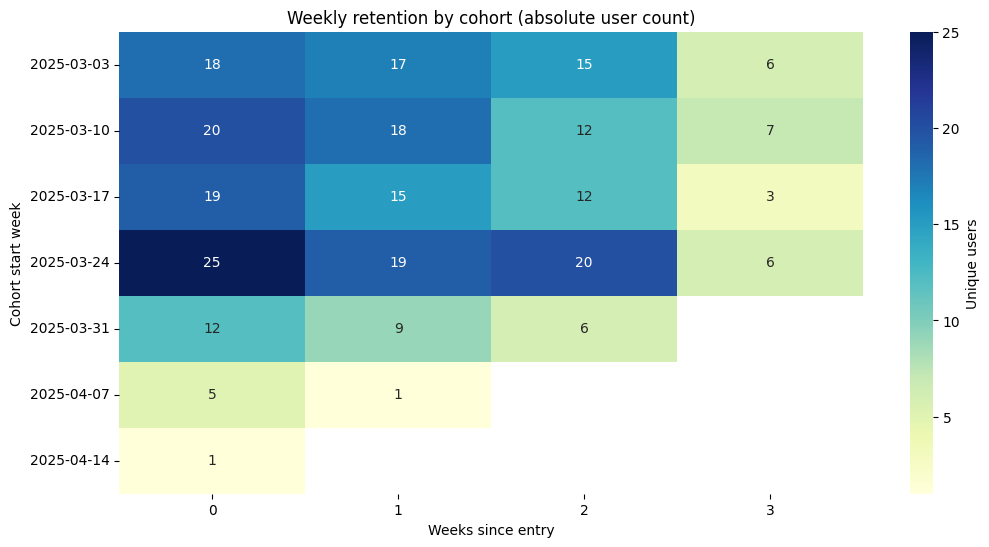

In [33]:
# Convert cohort index to string for cleaner y-axis labels
cohort_pivot.index = cohort_pivot.index.astype(str)

# Create figure for the heatmap
plt.figure(figsize=(12, 6))

# Generate the heatmap showing absolute user counts per cohort/week
sns.heatmap(
    cohort_pivot,
    annot=True,             # Display values in each cell
    fmt=".0f",              # No decimal places
    cmap="YlGnBu",          # Color palette
    cbar_kws={'label': 'Unique users'}  # Label for the color bar
)

# Add title and axis labels
plt.title("Weekly retention by cohort (absolute user count)")
plt.xlabel("Weeks since entry")
plt.ylabel("Cohort start week")

# Rotate y-axis labels horizontally for readability
plt.yticks(rotation=0)

# Show the plot
plt.show()

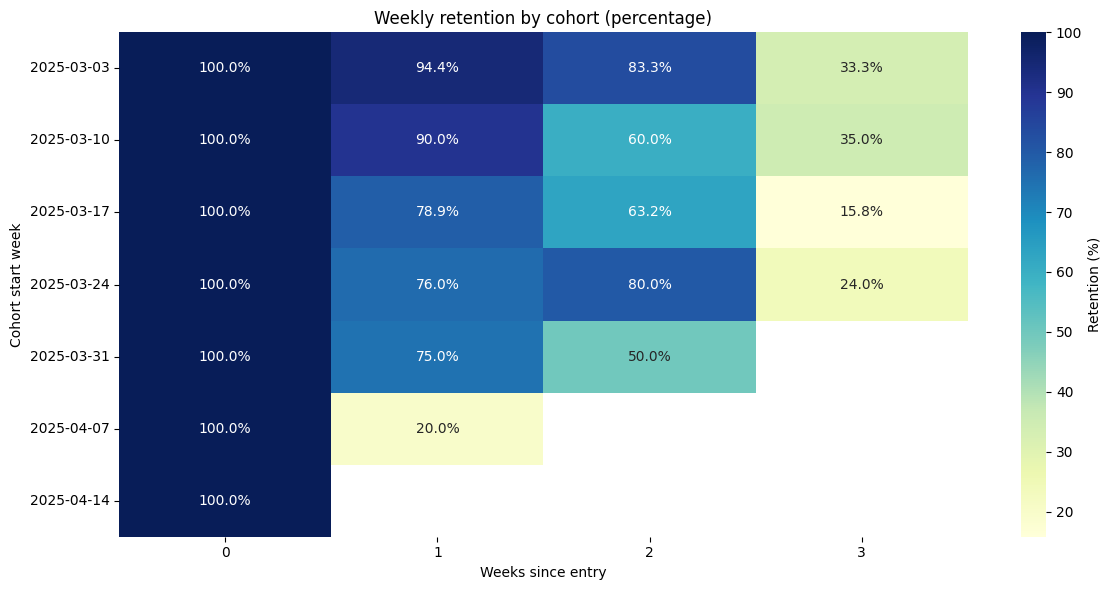

In [32]:
# Calculate percentage retention based on cohort size (week 0 = 100%)
cohort_percent = cohort_pivot.divide(cohort_pivot[0], axis=0) * 100

# Convert index to string to ensure proper Y-axis label rotation
cohort_percent.index = cohort_percent.index.astype(str)

# Format values as strings with '%' symbol for cleaner annotation
cohort_annotation = cohort_percent.round(1).astype(str) + '%'

# Create the percentage retention heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    cohort_percent,
    annot=cohort_annotation,   # Show percentage values inside the cells
    fmt="s",                   # 's' means each value is already a string
    cmap="YlGnBu",
    cbar_kws={'label': 'Retention (%)'}  # Color bar label
)

# Titles and axis labels
plt.title("Weekly retention by cohort (percentage)")
plt.xlabel("Weeks since entry")
plt.ylabel("Cohort start week")
plt.yticks(rotation=0)  # Make Y-axis labels horizontal for readability
plt.tight_layout()
plt.show()